# Import dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import pickle
from scipy.signal import savgol_filter
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Add, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, MaxPool1D, AveragePooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, confusion_matrix)
from PIL import ImageFont

!pip install keras-tuner
!pip install visualkeras
!pip install torchinfo

from torchinfo import summary
import keras_tuner as kt
import visualkeras

# Import dataset retrieved from GitHub

ref: [Covid Dataset](https://github.com/MIND-Lab/Raman-Spectra-Data)

In [ ]:
raw_data_pd = pd.read_pickle(r'/content/data_raw.pkl')

# "Utils" methods

This section is composed by method used in different section of the notebook.

In [ ]:
def plot_spectra(df, xlabel=None, ylabel=None, title=None):
  for i, curr_row in  df.iterrows():
    plt.plot(curr_row['x-axis'], curr_row['spectra'])

  plt.grid(color='grey')
  plt.title(title if title is not None else "")
  plt.xlabel(xlabel if xlabel is not None else 'Raman Shift [cm⁻¹]')
  plt.ylabel(ylabel if ylabel is not None else 'Intensity [a.u.]')
  plt.show()

def plot_and_save_spectra_img(df, filename, xlabel=None, ylabel=None, title=None):
  for i, curr_row in  df.iterrows():
    plt.plot(curr_row['x-axis'], curr_row['spectra'])

  plt.grid(color='grey')
  plt.title(title if title is not None else "")
  plt.xlabel(xlabel if xlabel is not None else 'Raman Shift [cm⁻¹]')
  plt.ylabel(ylabel if ylabel is not None else 'Intensity [a.u.]')
  plt.savefig(filename, dpi=300)
  plt.show()

# Utility methods to plot Loss and Accuracy related to epochs
def plot_loss(history):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

def plot_history(history, title):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title(f'{title} - Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()

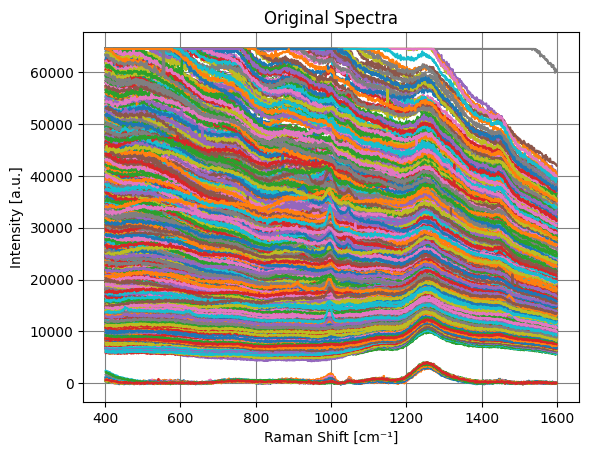

In [ ]:
plot_and_save_spectra_img(raw_data_pd, filename="spectra_original", title="Original Spectra")

# Outlier removal

In [ ]:
def remove_outliers(spectra, saturation_threshold=60000):
    """
    Remove outliers from spectra based only on saturation threshold.

    Parameters:
    - spectra: DataFrame column or numpy array of spectra (each row is a spectrum).
    - saturation_threshold: float, threshold for saturation detection.

    Returns:
    - filtered_spectra: Filtered spectra after removing outliers.
    - retained_indices: Indices of the spectra that were retained.
    - eliminated_spectra: Spectra that were eliminated.
    - eliminated_indices: Indices of the eliminated spectra.
    """
    filtered_spectra = []
    eliminated_spectra = []
    retained_indices = []
    eliminated_indices = []

    for i, spectrum in enumerate(spectra):
        spectrum = np.array(spectrum)

        # Check for sequence of repeated values above saturation threshold
        repeated_values = np.diff(spectrum) == 0  # Check for consecutive equal values
        repeated_high_values = np.logical_and(spectrum[:-1] > saturation_threshold, repeated_values)
        repeated_high_ratio = np.sum(repeated_high_values) / len(spectrum)

        # Include the spectrum if it doesn't show saturation
        if repeated_high_ratio == 0:
            filtered_spectra.append(spectrum)
            retained_indices.append(i)
        else:
            eliminated_spectra.append(spectrum)
            eliminated_indices.append(i)

    return (np.array(filtered_spectra),
            retained_indices,
            np.array(eliminated_spectra),
            eliminated_indices)

Number of spectra removed: 87


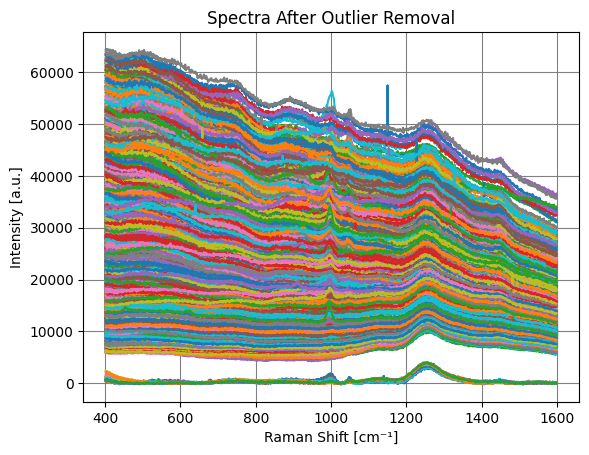

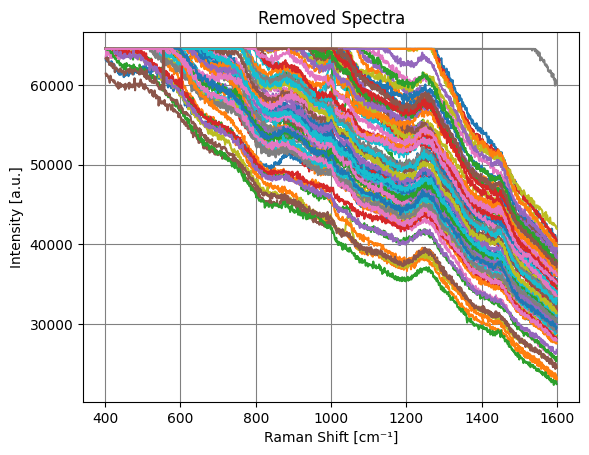

In [ ]:
spectra = raw_data_pd['spectra']
x_axis = raw_data_pd['x-axis']

# Apply outlier removal and create a new df
filtered_spectra, retained_indices, eliminated_spectra, eliminated_indices = remove_outliers(spectra)
filtered_data = raw_data_pd.iloc[retained_indices].copy()

eliminated_data = raw_data_pd.iloc[eliminated_indices].copy()

# Save new df without outlier
filtered_data_path = '/content/filtered_data.pkl'
filtered_data.to_pickle(filtered_data_path)

# Print the number of spectra removed
num_removed = len(spectra) - len(filtered_spectra)
print(f"Number of spectra removed: {num_removed}")

plot_and_save_spectra_img(filtered_data, filename="spectra_without_outliers", title="Spectra After Outlier Removal")
plot_and_save_spectra_img(eliminated_data, filename="spectra_with_outliers", title="Removed Spectra")

# Polynomial fitting background

In [ ]:
# Define polynomial fitting background correction function
def polynomial_background_correction(spectrum, degree=3):
    x = np.arange(len(spectrum))
    coeffs = np.polyfit(x, spectrum, degree)
    background = np.polyval(coeffs, x)
    corrected_spectrum = spectrum - background
    return corrected_spectrum

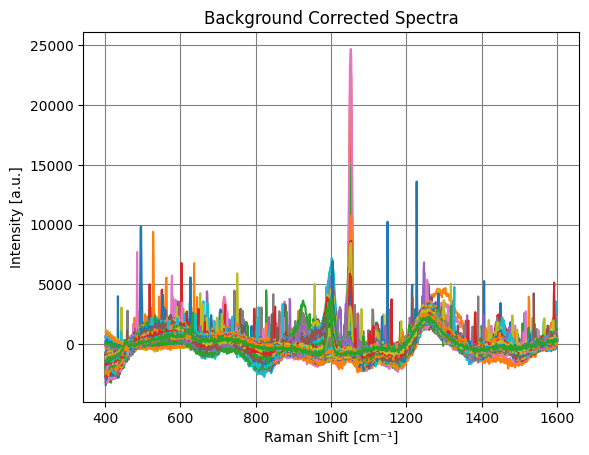

In [ ]:
# Apply Background Correction
filtered_data['spectra'] = filtered_data['spectra'].apply(polynomial_background_correction)

# Plot settings
plot_and_save_spectra_img(filtered_data, filename="spectra_back_corrected", title='Background Corrected Spectra')

In [ ]:
filtered_data.head()

,user,name,raw,spectra,category,x-axis
0,COV+_01,Raw,True,"[-1571.5208296007168, -1515.2923044057516, -15...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
1,COV+_01,Raw,True,"[-1634.6095684235715, -1543.1203893448528, -15...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
2,COV+_01,Raw,True,"[-1644.6578756850795, -1803.3508481981444, -19...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
3,COV+_01,Raw,True,"[-2233.5389467977875, -1869.8984629813785, -21...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
4,COV+_01,Raw,True,"[-1751.195527724747, -1653.4705777823328, -172...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."


# Despiking based on Hayes-Whitaker algorithm

ref: [A simple algorithm for despiking Raman spectra](https://www.sciencedirect.com/science/article/abs/pii/S0169743918301758?fr=RR-2&ref=pdf_download&rr=907bef2a9d29ea40)

In [ ]:
# Define helper function to replace spikes with neighbor averages
def replace_with_neighbors(spectrum, spike_indices, neighborhood_size):
    """
    Replaces spikes in the spectrum with the mean of their valid neighbors.

    Parameters:
        spectrum (array-like): The input Raman spectrum.
        spike_indices (array-like): Indices of detected spikes.
        neighborhood_size (int): The number of neighbors to use for replacement.

    Returns:
        array-like: The spectrum with spikes replaced.
    """
    for idx in spike_indices:
        # Determine the neighborhood bounds
        start = max(idx - neighborhood_size, 0)
        end = min(idx + neighborhood_size + 1, len(spectrum))

        # Gather non-spike neighbors
        neighbors = [spectrum[i] for i in range(start, end) if i != idx and i not in spike_indices]

        # Replace the spike with the mean of its neighbors
        if neighbors:
            spectrum[idx] = np.mean(neighbors)

    return spectrum

# Define despiking function using modified Z-scores
def despike_spectrum(spectrum, threshold=6, neighborhood_size=5):
    """
    Removes spikes from a spectrum using modified Z-scores and neighbor averaging.

    Parameters:
        spectrum (array-like): The input Raman spectrum.
        threshold (float): The Z-score threshold for detecting spikes.
        neighborhood_size (int): The number of neighbors to use for spike replacement.

    Returns:
        array-like: The despiked spectrum.
    """
    # Compute the differenced spectrum
    differenced = np.diff(spectrum, prepend=0)

    # Calculate the median and median absolute deviation (MAD)
    median = np.median(differenced)
    mad = np.median(np.abs(differenced - median))

    # Compute modified Z-scores
    z_scores = 0.6745 * (differenced - median) / mad

    # Identify spike indices based on the threshold
    spike_indices = np.where(np.abs(z_scores) > threshold)[0]

    # Replace spikes with the mean of their valid neighbors
    spectrum = replace_with_neighbors(spectrum, spike_indices, neighborhood_size)

    return spectrum

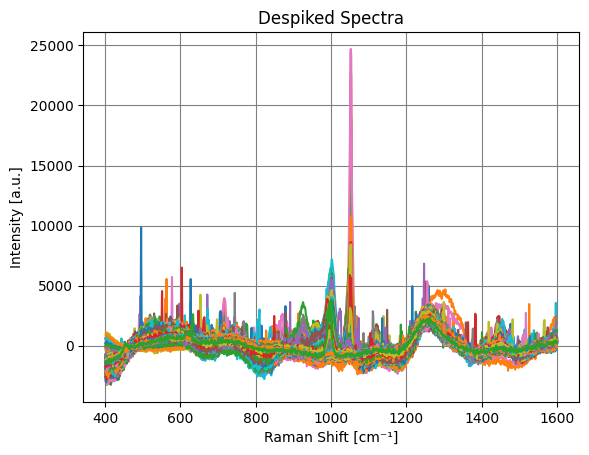

,user,name,raw,spectra,category,x-axis
0,COV+_01,Raw,True,"[-1579.0609594101013, -1515.2923044057516, -15...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
1,COV+_01,Raw,True,"[-1565.5244213453352, -1543.1203893448528, -15...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
2,COV+_01,Raw,True,"[-1769.3430740586925, -1803.3508481981444, -19...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
3,COV+_01,Raw,True,"[-1900.8714667852953, -1869.8984629813785, -21...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."
4,COV+_01,Raw,True,"[-1728.19171654545, -1653.4705777823328, -1721...",COV+,"[401.286, 402.641, 403.996, 405.35, 406.705, 4..."


In [ ]:
# Apply despiking to the spectra
corrected_spectra = []
for spectrum in filtered_data['spectra']:
    # Despike the spectrum
    despiked_spectrum = despike_spectrum(np.copy(spectrum))
    corrected_spectra.append(despiked_spectrum)

filtered_data['spectra'] = corrected_spectra
plot_and_save_spectra_img(filtered_data, filename="despiked_spectra", title='Despiked Spectra')

filtered_data.head()

# Data augmentation
ref: https://arxiv.org/pdf/1710.01927

(18504, 991)


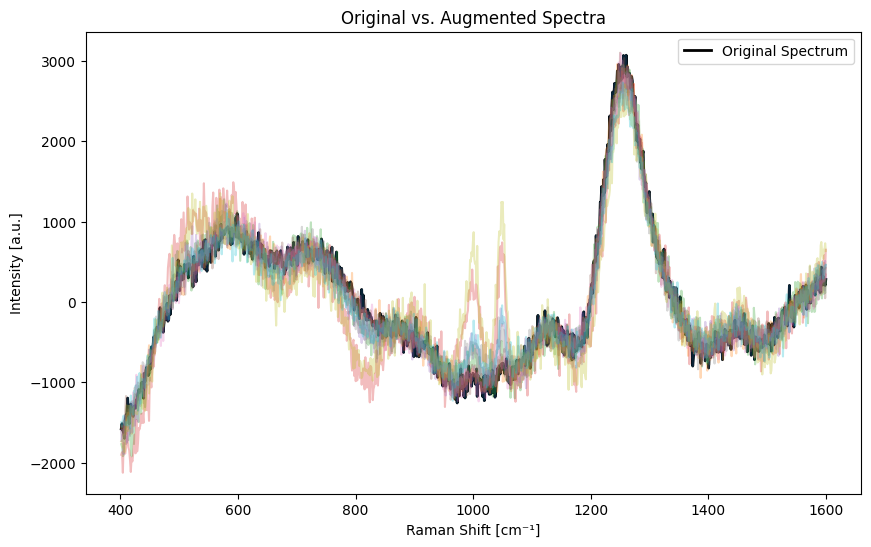

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# Extract spectral data
spectra_data = np.array(filtered_data["spectra"].tolist())


def augment_spectral_data(spectra, num_augmentations=7):
    """
    Applies random offsets, slope changes, and multiplicative noise to spectral data.

    Parameters:
    spectra (numpy array): Original spectral data (samples x features).
    num_augmentations (int): Number of augmented samples per original sample.

    Returns:
    numpy array: Augmented spectral dataset.
    """
    augmented_spectra = []
    std_dev = np.std(spectra, axis=0)

    for spectrum in spectra:
        for _ in range(num_augmentations):
            offset = np.random.uniform(-0.10 * std_dev, 0.10 * std_dev)
            slope = np.random.uniform(0.95, 1.05)
            multiplication = np.random.uniform(1 - 0.10 * std_dev, 1 + 0.10 * std_dev)

            augmented_spectrum = (spectrum + offset) * slope * multiplication
            augmented_spectra.append(augmented_spectrum)

    return np.vstack([spectra] + augmented_spectra)

# Apply augmentation
augmented_spectra = augment_spectral_data(spectra_data)
print(augmented_spectra.shape)

# Plot original and augmented spectra
plt.figure(figsize=(10, 6))
plt.plot(filtered_data["x-axis"].iloc[0], spectra_data[0], label="Original Spectrum", linewidth=2, color="black")
for i in range(10):
    plt.plot(filtered_data["x-axis"].iloc[0], augmented_spectra[i], alpha=0.3,linewidth=1.5)
plt.xlabel("Raman Shift [cm⁻¹]")
plt.ylabel("Intensity [a.u.]")
plt.title("Original vs. Augmented Spectra")
plt.legend()
plt.savefig("original_vs_augmented_spectra.png", dpi=300)
plt.show()


# Preprocessing for the training phase

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_encoder = LabelEncoder()
scaler = StandardScaler()

#x_train = augmented_spectra
x_train = scaler.fit_transform(augmented_spectra)
y_train_encoded = np.repeat(label_encoder.fit_transform(filtered_data['category']), 8)
y_train = to_categorical(y_train_encoded, num_classes=len(label_encoder.classes_))

# First split to a "temp" cause i want to split again to create val and test
x_train, x_temp, y_train, y_temp = train_test_split(
    x_train, y_train, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_val shape: ", x_val.shape)
print("y_val shape: ", y_val.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (12952, 991)
y_train shape:  (12952, 3)
x_val shape:  (2776, 991)
y_val shape:  (2776, 3)
x_test shape:  (2776, 991)
y_test shape:  (2776, 3)


# Callbacks

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

# VGG-like Model

## Architecture

In [ ]:
def build_vgg_model(hp=None, param_tuning=True):

    if param_tuning is True:
      first_block = hp.Int('first_block', min_value=16, max_value=64, step=16)
      second_block = hp.Int('second_block', min_value=8, max_value=32, step=8)
      third_block = hp.Int('third_block', min_value=4, max_value=16, step=4)
      dense_1 = hp.Int('dense_1', min_value=64, max_value=256, step=64)
      dense_2 = hp.Int('dense_2', min_value=32, max_value=128, step=32)
      dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.1, max_value=0.7, step=0.1)
      dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.1, max_value=0.7, step=0.1)
      learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    else:
      first_block = 32
      second_block = 16
      third_block = 8
      dense_1 = 128
      dense_2 = 64
      dropout_rate_1 = 0.5
      dropout_rate_2 = 0.5
      learning_rate = 0.0001 #1e-4

    _input = Input((991, 1))

    conv1 = Conv1D(filters=first_block, kernel_size=3, padding="same", activation="relu")(_input)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv1D(filters=first_block, kernel_size=3, padding="same", activation="relu")(conv1)
    conv2 = BatchNormalization()(conv2)
    pool1 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(filters=second_block, kernel_size=3, padding="same", activation="relu")(pool1)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv1D(filters=second_block, kernel_size=3, padding="same", activation="relu")(conv3)
    conv4 = BatchNormalization()(conv4)
    pool2 = MaxPooling1D(pool_size=2)(conv4)

    conv5 = Conv1D(filters=third_block, kernel_size=3, padding="same", activation="relu")(pool2)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv1D(filters=third_block, kernel_size=3, padding="same", activation="relu")(conv5)
    conv6 = BatchNormalization()(conv6)
    pool3 = MaxPooling1D(pool_size=2)(conv6)

    flat = Flatten()(pool3)
    dense1 = Dense(dense_1, activation="relu")(flat)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(dropout_rate_1)(dense1)
    dense2 = Dense(dense_2, activation="relu")(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(dropout_rate_2)(dense2)
    output = Dense(3, activation="softmax")(dense2)

    model = Model(inputs=_input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Our parameters
Based on a trial and error process

In [ ]:
vgg16_1d_model = build_vgg_model(param_tuning=False)
vgg16_1d_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 991, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_86 (Conv1D)                   │ (None, 991, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_83               │ (None, 991, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_87 (Conv1D)                   │ (None, 991, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_84               │ (None, 991, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 495, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_88 (Conv1D)                   │ (None, 495, 16)             │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_85               │ (None, 495, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_89 (Conv1D)                   │ (None, 495, 16)             │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_86               │ (None, 495, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 247, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_90 (Conv1D)                   │ (None, 247, 8)              │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_87               │ (None, 247, 8)              │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_91 (Conv1D)                   │ (None, 247, 8)              │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_88               │ (None, 247, 8)              │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 123, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 984)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         126,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 141,907 (554.32 KB)

 Trainable params: 141,299 (551.95 KB)

 Non-trainable params: 608 (2.38 KB)

In [ ]:
history_vgg16_1d_model = vgg16_1d_model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.4362 - loss: 1.6546 - val_accuracy: 0.5522 - val_loss: 0.9347
Epoch 2/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4996 - loss: 1.2670 - val_accuracy: 0.5879 - val_loss: 0.8563
Epoch 3/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5296 - loss: 1.1169 - val_accuracy: 0.6182 - val_loss: 0.8015
Epoch 4/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5601 - loss: 0.9945 - val_accuracy: 0.6488 - val_loss: 0.7589
Epoch 5/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5791 - loss: 0.9437 - val_accuracy: 0.6643 - val_loss: 0.7396
Epoch 6/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6104 - loss: 0.8724 - val_accuracy: 0.6816 - val_loss: 0.7125
Epoch 7/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6336 - loss: 0.8252 - val_accuracy: 0.6913 - val_loss: 0.6880
Epoch 8/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6479 - loss: 0.7995 

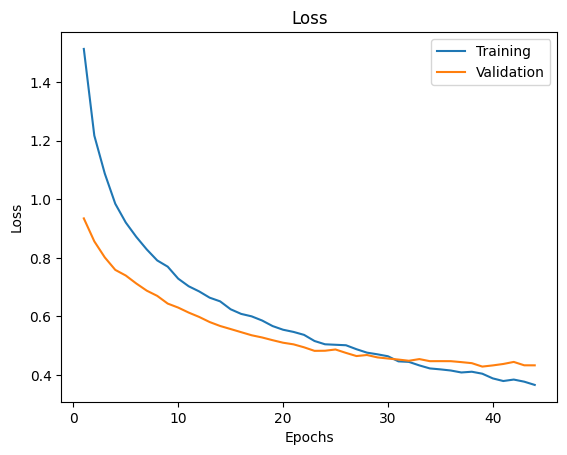

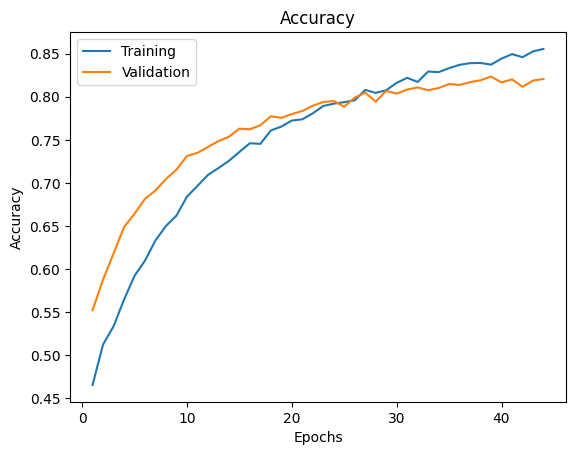

In [ ]:
plot_loss(history_vgg16_1d_model)
plot_accuracy(history_vgg16_1d_model)

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8348 - loss: 0.4276
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
              precision    recall  f1-score   support

        COV+       0.89      0.87      0.88       840
        COV-       0.85      0.79      0.82      1064
        CTRL       0.75      0.83      0.79       872

    accuracy                           0.83      2776
   macro avg       0.83      0.83      0.83      2776
weighted avg       0.83      0.83      0.83      2776

0.9494653043995651
0.9504677264234198


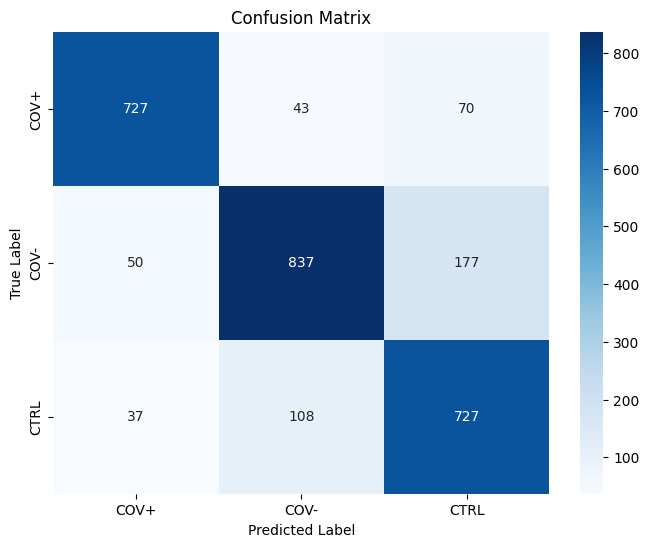

In [ ]:
model_evaluate = vgg16_1d_model.evaluate(x_test,y_test)
y_pred_prob = vgg16_1d_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
auc_roc_ovr = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
auc_roc_ovo = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')
print(report)
print(auc_roc_ovr)
print(auc_roc_ovo)
plot_confusion_matrix(y_true, y_pred, label_encoder.classes_, title='Confusion Matrix VGG-like Random Parameters')

## Tuned parameters

In [ ]:
tuner = kt.RandomSearch(
    build_vgg_model,
    objective='val_accuracy',
    max_trials=10,
    directory='vgg_tuning',
    project_name='vgg1d_tuning'
)

history = tuner.search(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

# After tuning, get the best model
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hp)
# Print the best hyperparameter values
print(f"Best Hyperparameters Found:")
print(f"  First Block Filters: {best_hp.get('first_block')}")
print(f"  Second Block Filters: {best_hp.get('second_block')}")
print(f"  Third Block Filters: {best_hp.get('third_block')}")
print(f"  Dense Layer 1 Units: {best_hp.get('dense_1')}")
print(f"  Dense Layer 2 Units: {best_hp.get('dense_2')}")
print(f"  Dropout Rate 1: {best_hp.get('dropout_rate_1')}")
print(f"  Dropout Rate 2: {best_hp.get('dropout_rate_2')}")
print(f"  Learning Rate: {best_hp.get('learning_rate')}")

Reloading Tuner from /content/drive/MyDrive/vgg_tuning/vgg1d_tuning/tuner0.json
Best Hyperparameters Found:
  First Block Filters: 64
  Second Block Filters: 16
  Third Block Filters: 16
  Dense Layer 1 Units: 256
  Dense Layer 2 Units: 128
  Dropout Rate 1: 0.1
  Dropout Rate 2: 0.2
  Learning Rate: 0.001


In [ ]:
best_model.summary()
history_best_model = best_model.fit(x_train, y_train,epochs=100, batch_size=16, validation_data=(x_val, y_val),callbacks=[early_stopping])

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 991, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_66 (Conv1D)                   │ (None, 991, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_88               │ (None, 991, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_67 (Conv1D)                   │ (None, 991, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_89               │ (None, 991, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 495, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_68 (Conv1D)                   │ (None, 495, 16)             │           3,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_90               │ (None, 495, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_69 (Conv1D)                   │ (None, 495, 16)             │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_91               │ (None, 495, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 247, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_70 (Conv1D)                   │ (None, 247, 16)             │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_92               │ (None, 247, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 247, 16)             │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_93               │ (None, 247, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 123, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 1968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │         504,064 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 557,699 (2.13 MB)

 Trainable params: 556,547 (2.12 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.6218 - loss: 0.9140 - val_accuracy: 0.7680 - val_loss: 0.5637
Epoch 2/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7653 - loss: 0.5617 - val_accuracy: 0.8105 - val_loss: 0.4417
Epoch 3/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7986 - loss: 0.4778 - val_accuracy: 0.8347 - val_loss: 0.4000
Epoch 4/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8388 - loss: 0.4042 - val_accuracy: 0.8555 - val_loss: 0.3677
Epoch 5/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8430 - loss: 0.3797 - val_accuracy: 0.8664 - val_loss: 0.3342
Epoch 6/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8728 - loss: 0.3284 - val_accuracy: 0.8682 - val_loss: 0.3248
Epoch 7/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8812 - loss: 0.3032 - val_accuracy: 0.8559 - val_loss: 0.3695
Epoch 8/100
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8827 - loss: 0.3003 - va

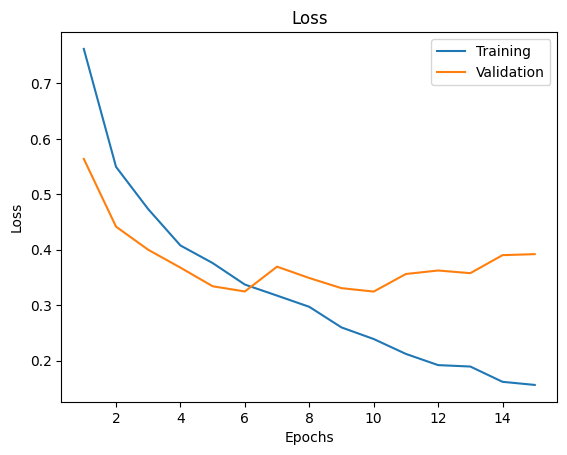

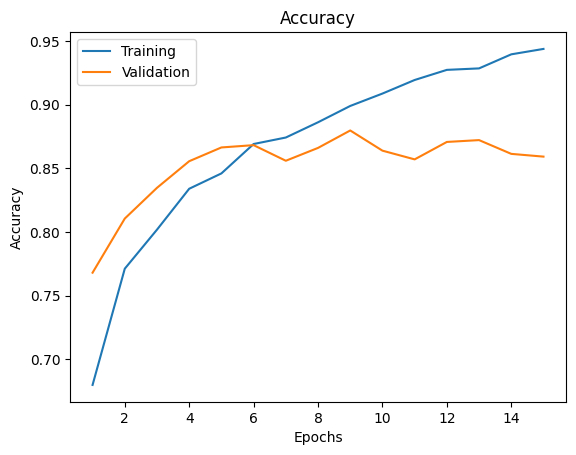

In [ ]:
plot_loss(history_best_model)
plot_accuracy(history_best_model)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8675 - loss: 0.3647
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

        COV+       0.90      0.90      0.90       840
        COV-       0.87      0.86      0.86      1064
        CTRL       0.83      0.84      0.83       872

    accuracy                           0.86      2776
   macro avg       0.87      0.87      0.87      2776
weighted avg       0.87      0.86      0.86      2776

0.9687419689892364
0.9693363966381661


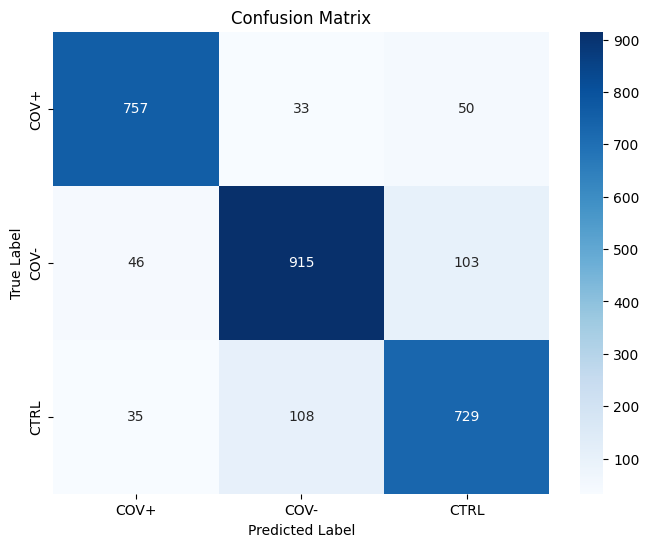

In [ ]:
model_evaluate = best_model.evaluate(x_test,y_test)
y_pred_prob = best_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
auc_roc_ovr = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
auc_roc_ovo = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')
print(report)
print(auc_roc_ovr)
print(auc_roc_ovo)

plot_confusion_matrix(y_true, y_pred, label_encoder.classes_, title='Confusion Matrix VGG-like Tuned Parameters')

# ResNet

## Architecture

In [ ]:
# Identity block with tunable filter size
def identity_block(x, filters):
    x_skip = x
    x = Conv1D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(axis=2)(x)

    if x_skip.shape[-1] != filters:
        x_skip = Conv1D(filters, kernel_size=1, padding='same')(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x

# Convolutional block with tunable filter size
def convolutional_block(x, filters):
    x_skip = x
    x = Conv1D(filters, kernel_size=3, padding='same', strides=2)(x)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(axis=2)(x)
    x_skip = Conv1D(filters, kernel_size=1, strides=2, padding='same')(x_skip)
    x = Add()([x, x_skip])
    x = Activation('relu')(x)
    return x

# Hyperparameter-tunable ResNet34 model
def build_resnet(hp=None, param_tuning=True):
    shape = (991, 1)
    classes = 3

    if param_tuning is True:
      # Tune the number of filters in the first conv layer
      initial_filters = hp.Int('initial_filters', min_value=8, max_value=64, step=8)
      # Tune the base filter size and number of blocks per layer
      base_filter_size = hp.Int('base_filter_size', min_value=8, max_value=64, step=8)
      # Tune the dense layer size
      dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
      dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
      learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    else:
      initial_filters = 8
      base_filter_size = 8
      dense_units = 128
      dropout_rate = 0.0
      learning_rate = 0.00001


    x_input = Input(shape)
    x = ZeroPadding1D((3, 3))(x_input)

    x = Conv1D(initial_filters, kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool1D(pool_size=3, strides=2, padding='same')(x)



    # Tune the number of blocks per layer
    block_layers = [3, 4, 6, 3]

    filter_size = base_filter_size

    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            filter_size *= 2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)

    x = AveragePooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)

    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(classes, activation='softmax')(x)
    model = Model(inputs=x_input, outputs=x, name="ResNet34")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Our Parameters

In [ ]:
resnet_model = build_resnet(param_tuning=False)
resnet_model.summary()

Model: "ResNet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 991, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding1d            │ (None, 997, 1)         │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding1D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_50 (Conv1D)        │ (None, 499, 8)         │             64 │ zero_padding1d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 499, 8)         │             32 │ conv1d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_50             │ (None, 499, 8)         │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 250, 8)         │              0 │ activation_50[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)        │ (None, 250, 8)         │            200 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 250, 8)         │             32 │ conv1d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_51             │ (None, 250, 8)         │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_52 (Conv1D)        │ (None, 250, 8)         │            200 │ activation_51[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_52    │ (None, 250, 8)         │             32 │ conv1d_52[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 250, 8)         │              0 │ batch_normalization_5… │
│                           │                        │                │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_52             │ (None, 250, 8)         │              0 │ add[0][0]              │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_53 (Conv1D)        │ (None, 250, 8)         │            200 │ activation_52[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5

 Total params: 249,027 (972.76 KB)

 Trainable params: 247,123 (965.32 KB)

 Non-trainable params: 1,904 (7.44 KB)

In [ ]:
history_resnet_model = resnet_model.fit(x_train, y_train, batch_size=8, epochs=50, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - accuracy: 0.4634 - loss: 1.1998 - val_accuracy: 0.5050 - val_loss: 1.0205
Epoch 2/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5134 - loss: 0.9977 - val_accuracy: 0.5321 - val_loss: 0.9650
Epoch 3/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5232 - loss: 0.9513 - val_accuracy: 0.5439 - val_loss: 0.9325
Epoch 4/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5612 - loss: 0.8965 - val_accuracy: 0.5558 - val_loss: 0.9190
Epoch 5/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5709 - loss: 0.8817 - val_accuracy: 0.5674 - val_loss: 0.9024
Epoch 6/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5702 - loss: 0.8565 - val_accuracy: 0.5638 - val_loss: 0.8844
Epoch 7/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5933 - loss: 0.8371 - val_accuracy: 0.5764 - val_loss: 0.8746
Epoch 8/50
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6059 -

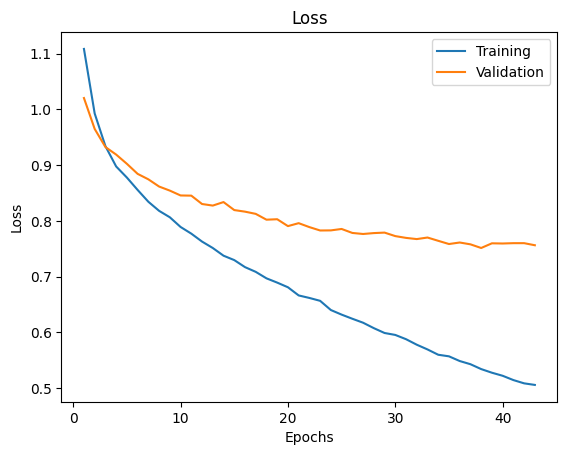

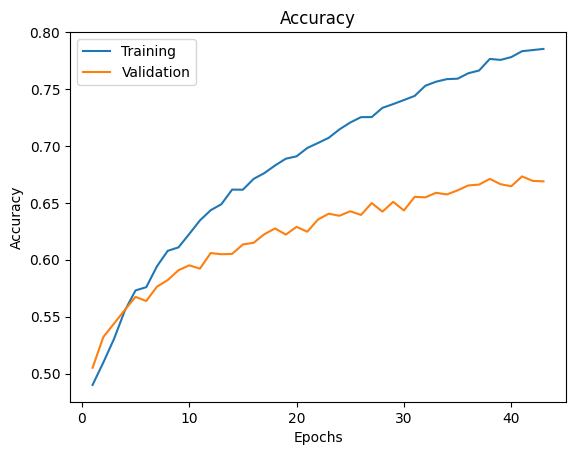

In [ ]:
plot_loss(history_resnet_model)
plot_accuracy(history_resnet_model)

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6398 - loss: 0.7773
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
              precision    recall  f1-score   support

        COV+       0.75      0.65      0.70       840
        COV-       0.68      0.65      0.66      1064
        CTRL       0.58      0.67      0.62       872

    accuracy                           0.66      2776
   macro avg       0.67      0.66      0.66      2776
weighted avg       0.67      0.66      0.66      2776

0.8409611342588402
0.8428165761717531


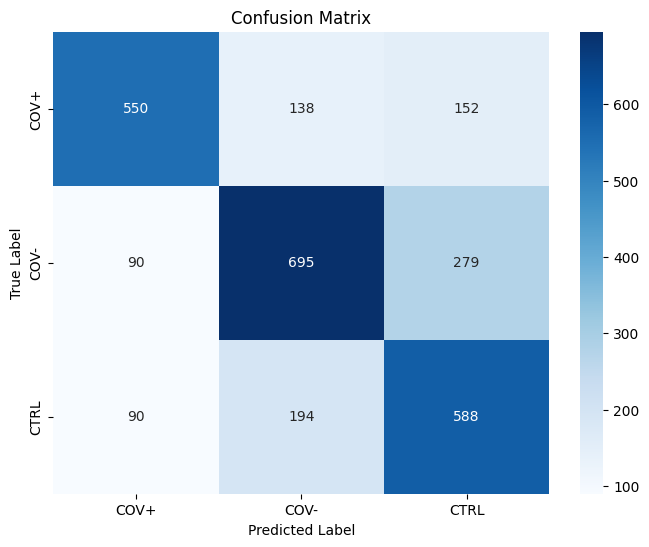

In [ ]:
model_evaluate = resnet_model.evaluate(x_test,y_test)
y_pred_prob = resnet_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
auc_roc_ovr = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
auc_roc_ovo = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')
print(report)
print(auc_roc_ovr)
print(auc_roc_ovo)
plot_confusion_matrix(y_true, y_pred, label_encoder.classes_, title='Confusion Matrix ResNet Random Parameters')

## Tuned Parameters

In [ ]:
tuner = kt.RandomSearch(
    build_resnet,
    objective='val_accuracy',
    max_trials=10,
    directory='resnet_tuning',
    project_name='resnet1d_tuning'
)

history = tuner.search(
    x_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

# Retrieve best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Print best hyperparameter values
print(f"Best Hyperparameters Found:")
print(f"  Initial Filters: {best_hp.get('initial_filters')}")
print(f"  Base Filter Size: {best_hp.get('base_filter_size')}")
print(f"  Dense Units: {best_hp.get('dense_units')}")
print(f"  Dropout Rate: {best_hp.get('dropout_rate')}")

Reloading Tuner from resnet_tuning/resnet1d_tuning/tuner0.json
Best Hyperparameters Found:
  Initial Filters: 56
  Base Filter Size: 32
  Dense Units: 256
  Dropout Rate: 0.5


In [ ]:

# Train the best model
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()
history_best_model = best_model.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stopping])

Model: "ResNet34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 991, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding1d_1          │ (None, 997, 1)         │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding1D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 499, 56)        │            448 │ zero_padding1d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 499, 56)        │            224 │ conv1d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_33             │ (None, 499, 56)        │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 250, 56)        │              0 │ activation_33[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_37 (Conv1D)        │ (None, 250, 32)        │          5,408 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 250, 32)        │            128 │ conv1d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_34             │ (None, 250, 32)        │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_38 (Conv1D)        │ (None, 250, 32)        │          3,104 │ activation_34[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 250, 32)        │            128 │ conv1d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_39 (Conv1D)        │ (None, 250, 32)        │          1,824 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 250, 32)        │              0 │ batch_normalization_3… │
│                           │                        │                │ conv1d_39[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_35             │ (None, 250, 32)        │              0 │ add_16[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_40 (Conv1D)   

 Total params: 2,873,923 (10.96 MB)

 Trainable params: 2,866,259 (10.93 MB)

 Non-trainable params: 7,664 (29.94 KB)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 74s 43ms/step - accuracy: 0.5065 - loss: 1.5367 - val_accuracy: 0.6877 - val_loss: 0.7675
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6146 - loss: 0.7905 - val_accuracy: 0.7104 - val_loss: 0.6561
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6630 - loss: 0.7152 - val_accuracy: 0.7356 - val_loss: 0.6059
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7030 - loss: 0.6609 - val_accuracy: 0.7201 - val_loss: 0.6005
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7115 - loss: 0.6427 - val_accuracy: 0.7803 - val_loss: 0.5183
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7386 - loss: 0.5904 - val_accuracy: 0.7889 - val_loss: 0.5189
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7518 - loss: 0.5757 - val_accuracy: 0.7788 - val_loss: 0.5283
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.7562 - loss: 0.5545 - 

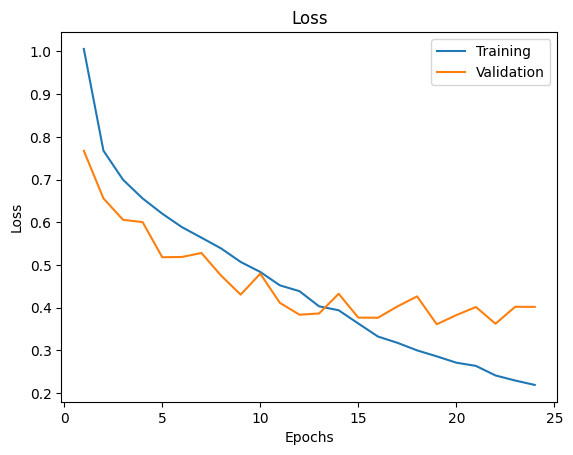

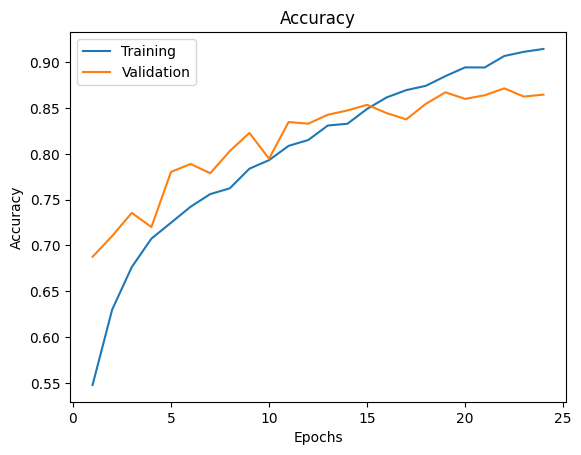

In [ ]:
plot_loss(history_best_model)
plot_accuracy(history_best_model)

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8556 - loss: 0.4286
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
              precision    recall  f1-score   support

        COV+       0.94      0.86      0.90       840
        COV-       0.89      0.82      0.86      1064
        CTRL       0.77      0.91      0.83       872

    accuracy                           0.86      2776
   macro avg       0.87      0.86      0.86      2776
weighted avg       0.87      0.86      0.86      2776

0.9651636215982381
0.9658098819159081


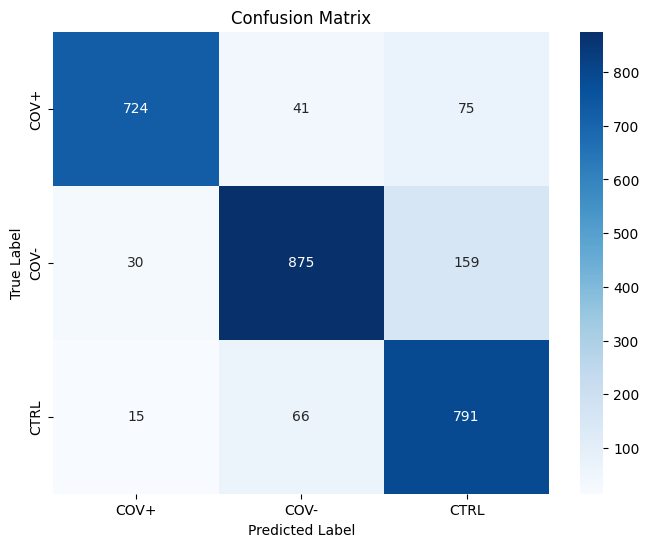

In [ ]:
model_evaluate = best_model.evaluate(x_test,y_test)
y_pred_prob = best_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
auc_roc_ovr = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
auc_roc_ovo = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')
print(report)
print(auc_roc_ovr)
print(auc_roc_ovo)
plot_confusion_matrix(y_true, y_pred, label_encoder.classes_, title='Confusion Matrix ResNet Tuned Parameters')

# DenseNet

## Architecture

In [ ]:
def denseblock(input, hp, num_filter, param_tuning):
    if param_tuning is True:
      compression = hp.Float("compression", min_value=0.2, max_value=0.6, step=0.1)
      dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
      num_layers = hp.Int("num_layers_per_block", min_value=3, max_value=7, step=1)
    else:
      compression = 0.2
      dropout_rate = 0.2
      num_layers = 7

    temp = input
    for _ in range(num_layers):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv1D_layer = Conv1D(int(num_filter * compression), kernel_size=3, use_bias=False, padding='same')(relu)
        if dropout_rate > 0:
            Conv1D_layer = Dropout(dropout_rate)(Conv1D_layer)
        temp = Concatenate(axis=-1)([temp, Conv1D_layer])
    return temp

def transition(input, hp, num_filter, param_tuning):
    if param_tuning is True:
      compression = hp.Float("compression", min_value=0.2, max_value=0.6, step=0.1)
      dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    else:
      compression = 0.2
      dropout_rate = 0.2

    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv1D_BottleNeck = Conv1D(int(num_filter * compression), kernel_size=1, use_bias=False, padding='same')(relu)
    if dropout_rate > 0:
        Conv1D_BottleNeck = Dropout(dropout_rate)(Conv1D_BottleNeck)
    avg = AveragePooling1D(pool_size=2)(Conv1D_BottleNeck)
    return avg

def output_layer(input, hp, param_tuning):
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling1D(pool_size=2)(relu)
    flat = Flatten()(AvgPooling)

    if param_tuning is True:
      dense_units = hp.Int("dense_units", min_value=64, max_value=256, step=64)
      dropout_rate = hp.Float("dropout_rate_dense", min_value=0.1, max_value=0.5, step=0.1)
    else:
      dense_units = 64
      dropout_rate = 0.1

    dense = Dense(dense_units, activation='relu')(flat)
    dense = Dropout(dropout_rate)(dense)

    output = Dense(3, activation='softmax')(dense)
    return output

def build_densenet(hp=None, param_tuning=True):
    input = Input(shape=(991, 1))

    if param_tuning is True:
      initial_filters = hp.Int("initial_filters", min_value=16, max_value=64, step=8)
      First_Conv1D = Conv1D(initial_filters, kernel_size=3, use_bias=False, padding='same')(input)

      num_dense_blocks = hp.Int("num_dense_blocks", min_value=2, max_value=5, step=1)
      num_filter = hp.Int("num_filters_per_block", min_value=16, max_value=64, step=8)
      learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4, 1e-5])
    else:
      num_dense_blocks = 2
      initial_filters = 30
      num_filter = 20
      First_Conv1D = Conv1D(initial_filters, kernel_size=3, use_bias=False, padding='same')(input)
      learning_rate = 0.00001

    x = First_Conv1D
    for _ in range(num_dense_blocks):
        x = denseblock(x, hp, num_filter, param_tuning)
        x = transition(x, hp, num_filter, param_tuning)

    output = output_layer(x, hp, param_tuning)
    model = Model(inputs=[input], outputs=[output])


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

## Our parameters

In [ ]:
densenet_model = build_densenet(param_tuning=False)
densenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 991, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_33 (Conv1D)        │ (None, 991, 30)        │             90 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 991, 30)        │            120 │ conv1d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_33             │ (None, 991, 30)        │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_34 (Conv1D)        │ (None, 991, 4)         │            360 │ activation_33[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout)      │ (None, 991, 4)         │              0 │ conv1d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_26            │ (None, 991, 34)        │              0 │ conv1d_33[0][0],       │
│ (Concatenate)             │                        │                │ dropout_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 991, 34)        │            136 │ concatenate_26[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_34             │ (None, 991, 34)        │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_35 (Conv1D)        │ (None, 991, 4)         │            408 │ activation_34[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 991, 4)         │              0 │ conv1d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_27            │ (None, 991, 38)        │              0 │ concatenate_26[0][0],  │
│ (Concatenate)             │                        │                │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 991, 38)        │            152 │ concatenate_27[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_35             │ (None, 991, 38)        │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 991, 4)         │            456 │ activation_35[0][0]    │
├──────────────────────

 Total params: 39,069 (152.61 KB)

 Trainable params: 38,069 (148.71 KB)

 Non-trainable params: 1,000 (3.91 KB)

In [ ]:
history_densenet_model = densenet_model.fit(x_train, y_train, batch_size=8, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_253']
Received: inputs=Tensor(shape=(8, 991))
  warnings.warn(msg)


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.3468 - loss: 1.2044 - val_accuracy: 0.3829 - val_loss: 1.0331
Epoch 2/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.4698 - loss: 1.0111 - val_accuracy: 0.4200 - val_loss: 0.9862
Epoch 3/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4923 - loss: 0.9631 - val_accuracy: 0.4744 - val_loss: 0.9363
Epoch 4/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5228 - loss: 0.9253 - val_accuracy: 0.5234 - val_loss: 0.8945
Epoch 5/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5633 - loss: 0.8867 - val_accuracy: 0.5418 - val_loss: 0.8693
Epoch 6/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5776 - loss: 0.8592 - val_accuracy: 0.5659 - val_loss: 0.8466
Epoch 7/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5947 - loss: 0.8413 - val_accuracy: 0.5825 - val_loss: 0.8283
Epoch 8/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6160 - loss: 0.814

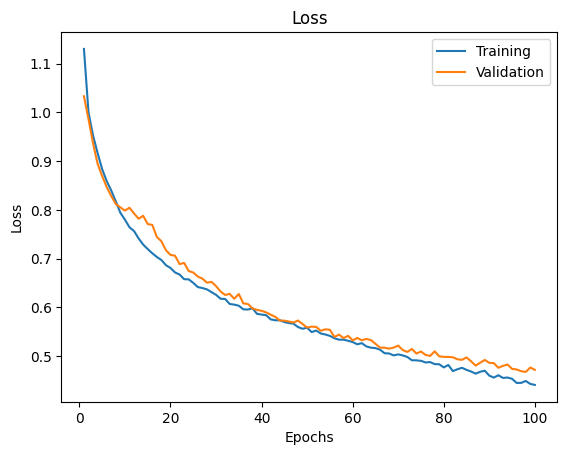

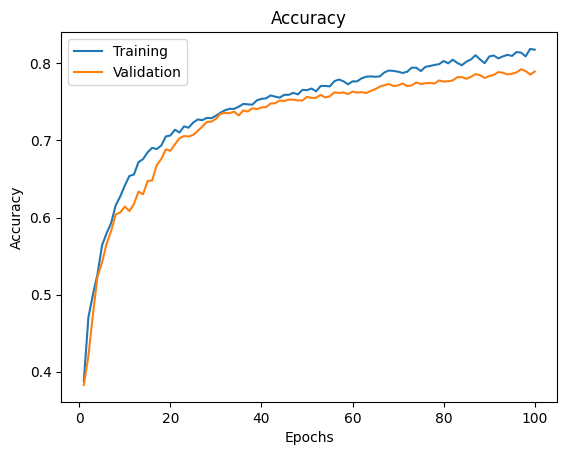

In [ ]:
plot_loss(history_densenet_model)
plot_accuracy(history_densenet_model)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_253']
Received: inputs=Tensor(shape=(None, 991))
  warnings.warn(msg)


87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7846 - loss: 0.4904


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_253']
Received: inputs=Tensor(shape=(32, 991))
  warnings.warn(msg)


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
              precision    recall  f1-score   support

        COV+       0.95      0.68      0.79       840
        COV-       0.76      0.82      0.79      1064
        CTRL       0.71      0.83      0.76       872

    accuracy                           0.78      2776
   macro avg       0.81      0.78      0.78      2776
weighted avg       0.80      0.78      0.78      2776

0.9374739366299504
0.9380762447019689


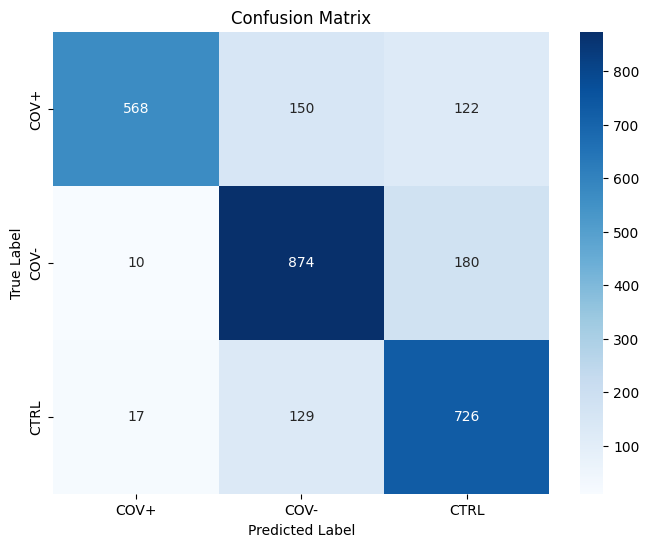

In [ ]:
model_evaluate = densenet_model.evaluate(x_test,y_test)
y_pred_prob = densenet_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
auc_roc_ovr = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
auc_roc_ovo = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')
print(report)
print(auc_roc_ovr)
print(auc_roc_ovo)
plot_confusion_matrix(y_true, y_pred, label_encoder.classes_, title='Confusion Matrix DenseNet Random Parameters')

## Tuned Parameters

In [ ]:
tuner = kt.RandomSearch(
    build_densenet,
    objective="val_accuracy",
    max_trials=10,
    directory="densenet_tuning",
    project_name="densenet1d_tuning"
)

tuner.search(
    x_train, y_train,
    epochs=100,
    batch_size=8,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

# Retrieve Best Hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

print(f"Best Hyperparameters Found:")
print(f"  Initial Filters: {best_hp.get('initial_filters')}")
print(f"  Num Dense Blocks: {best_hp.get('num_dense_blocks')}")
print(f"  Num Filters Per Block: {best_hp.get('num_filters_per_block')}")
print(f"  Compression: {best_hp.get('compression')}")
print(f"  Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"  Num Layers Per Block: {best_hp.get('num_layers_per_block')}")
print(f"  Dense Units: {best_hp.get('dense_units')}")
print(f"  Dropout Rate Dense: {best_hp.get('dropout_rate_dense')}")
print(f"  Learning Rate: {best_hp.get('learning_rate')}")

Trial 10 Complete [00h 06m 46s]
val_accuracy: 0.8206051588058472

Best val_accuracy So Far: 0.8890489935874939
Total elapsed time: 01h 03m 45s
Best Hyperparameters Found:
  Initial Filters: 24
  Num Dense Blocks: 3
  Num Filters Per Block: 24
  Compression: 0.30000000000000004
  Dropout Rate: 0.2
  Num Layers Per Block: 4
  Dense Units: 256
  Dropout Rate Dense: 0.1
  Learning Rate: 0.001


In [ ]:
# Train the best model
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()
history_best_model = best_model.fit(x_train, y_train, epochs=100, batch_size=8, validation_data=(x_val, y_val), callbacks=[early_stopping])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 991, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 991, 24)        │             72 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 991, 24)        │             96 │ conv1d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 991, 24)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 991, 7)         │            504 │ activation_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 991, 7)         │              0 │ conv1d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 991, 31)        │              0 │ conv1d_17[0][0],       │
│ (Concatenate)             │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 991, 31)        │            124 │ concatenate_14[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 991, 31)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 991, 7)         │            651 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 991, 7)         │              0 │ conv1d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 991, 38)        │              0 │ concatenate_14[0][0],  │
│ (Concatenate)             │                        │                │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 991, 38)        │            152 │ concatenate_15[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 991, 38)        │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 991, 7)         │            798 │ activation_19[0][0]    │
├──────────────────────

 Total params: 118,731 (463.79 KB)

 Trainable params: 117,917 (460.61 KB)

 Non-trainable params: 814 (3.18 KB)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_89']
Received: inputs=Tensor(shape=(8, 991))
  warnings.warn(msg)


1619/1619 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.6047 - loss: 0.8447 - val_accuracy: 0.7439 - val_loss: 0.5987
Epoch 2/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7542 - loss: 0.5648 - val_accuracy: 0.8159 - val_loss: 0.4514
Epoch 3/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8063 - loss: 0.4618 - val_accuracy: 0.8375 - val_loss: 0.3963
Epoch 4/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8277 - loss: 0.4113 - val_accuracy: 0.8419 - val_loss: 0.3700
Epoch 5/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8385 - loss: 0.3711 - val_accuracy: 0.8530 - val_loss: 0.3647
Epoch 6/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8666 - loss: 0.3334 - val_accuracy: 0.8548 - val_loss: 0.3357
Epoch 7/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8635 - loss: 0.3193 - val_accuracy: 0.8537 - val_loss: 0.3519
Epoch 8/100
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8801 - loss: 0.298

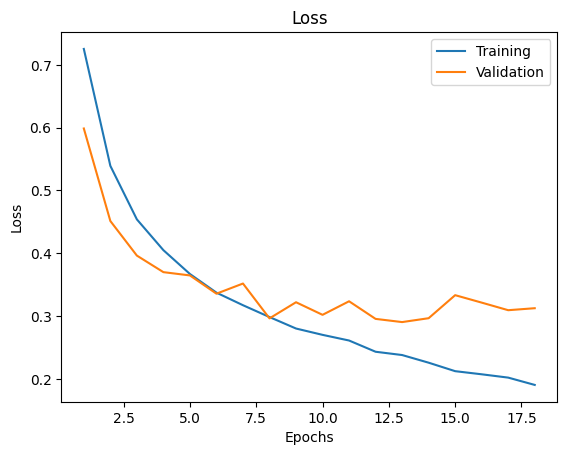

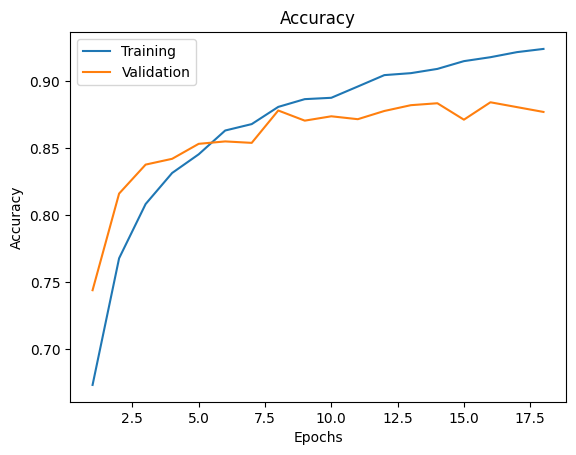

In [ ]:
plot_loss(history_best_model)
plot_accuracy(history_best_model)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_89']
Received: inputs=Tensor(shape=(None, 991))
  warnings.warn(msg)


87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8784 - loss: 0.3186


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_89']
Received: inputs=Tensor(shape=(32, 991))
  warnings.warn(msg)


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
              precision    recall  f1-score   support

        COV+       0.89      0.93      0.91       840
        COV-       0.94      0.80      0.86      1064
        CTRL       0.80      0.91      0.85       872

    accuracy                           0.87      2776
   macro avg       0.88      0.88      0.88      2776
weighted avg       0.88      0.87      0.87      2776

0.9748469757555432
0.9756007836802031


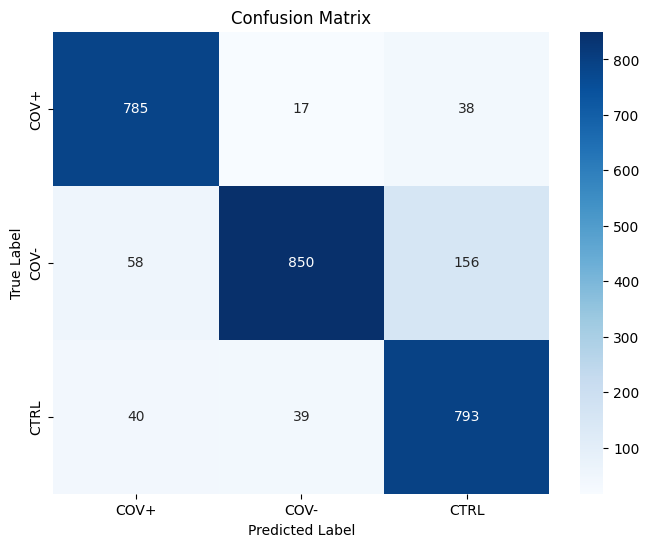

In [ ]:
model_evaluate = best_model.evaluate(x_test,y_test)
y_pred_prob = best_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
auc_roc_ovr = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
auc_roc_ovo = roc_auc_score(y_true, y_pred_prob, multi_class='ovo')
print(report)
print(auc_roc_ovr)
print(auc_roc_ovo)
plot_confusion_matrix(y_true, y_pred, label_encoder.classes_, title='Confusion Matrix DenseNet Random Parameters')

# Transformer

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np

class PatchEmbeddingAndPositionalEncoding1D(nn.Module):
    def __init__(self, spectra_size, patch_size, embedding_dim):
        super().__init__()
        self.spectra_size = spectra_size
        self.patch_size = patch_size

        # Calculate correct number of patches including padding
        self.padding = self._calculate_padding(spectra_size, patch_size)
        self.padded_size = spectra_size + self.padding
        self.num_patches = self.padded_size // patch_size
        self.projection = nn.Linear(patch_size, embedding_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embedding_dim))

    def forward(self, x):
        batch_size = x.shape[0]

        # Apply padding to avoid missmatch
        if self.padding > 0:
            x = torch.nn.functional.pad(x, (0, self.padding))

        # Create and project patches
        x = x.unfold(dimension=1, size=self.patch_size, step=self.patch_size)
        x = self.projection(x)

        # Add positional embeddings
        x = x + self.pos_embedding

        return x

    def _calculate_padding(self, spectra_size, patch_size):
        is_perfectly_divisible = spectra_size % patch_size == 0

        if is_perfectly_divisible:
            return 0

        # Calculate remaining elements and the padding to fill the necessary space
        remaining_elements = spectra_size % patch_size
        padding_needed = patch_size - remaining_elements

        return padding_needed

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedded_patches, num_heads, dropout):
        super().__init__()
        self.embedded_patches = embedded_patches

        # Multi-Head Self Attention components
        self.norm_msa = nn.LayerNorm(embedded_patches)
        self.msa = nn.MultiheadAttention(
            embed_dim=embedded_patches,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        # Feed Forward Network components
        self.norm_ffn = nn.LayerNorm(embedded_patches)
        self.ffn = nn.Sequential(
            nn.Linear(embedded_patches, embedded_patches * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embedded_patches * 4, embedded_patches),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Multi-Head Self Attention block
        x = self._msa_block(x)
        # Feed Forward Network block
        x = self._ffn_block(x)

        return x

    def _msa_block(self, x):
        identity = x

        # Layer normalization + attention
        x = self.norm_msa(x)
        attention_output, _ = self.msa(x, x, x)

        # Residual connection, which is the last part of the block
        return identity + attention_output

    def _ffn_block(self, x):
        identity = x

        # Layer normalization and FFN
        x = self.norm_ffn(x)
        ffn_output = self.ffn(x)

        # Residual connection, which is the last part of the block
        return identity + ffn_output

class ViT1D(nn.Module):
    def __init__(self, spectra_size, patch_size, num_classes, embedding_dim=256, depth=6, num_heads=8, dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbeddingAndPositionalEncoding1D(
            spectra_size=spectra_size,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )

        self.transformer_blocks = self._create_transformer_blocks(
            embedding_dim=embedding_dim,
            num_blocks=depth,
            num_heads=num_heads,
            dropout=dropout
        )

        self.norm = nn.LayerNorm(embedding_dim)

        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        # 1. Patch + Position embedding
        x = self.patch_embed(x)

        # 2. Transformer Encoding = MSA + MLP
        for block in self.transformer_blocks:
            x = block(x)

        #3. Final normalization
        x = self.norm(x)

        # Global average pooling
        x = torch.mean(x, dim=1)

        # Classification (MLP head block)
        x = self.classifier(x)

        return x

    def _create_transformer_blocks(self, embedding_dim, num_blocks, num_heads, dropout):
      blocks = []

      for _ in range(num_blocks):
          block = TransformerEncoderBlock(
              embedded_patches=embedding_dim,
              num_heads=num_heads,
              dropout=dropout
          )
          blocks.append(block)

      return nn.ModuleList(blocks)

In [ ]:
def train_and_evaluate(x_train, y_train, x_test, y_test, model, epochs, batch_size, learning_rate):
    # Create datasets and dataloaders
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    train_dataset = TensorDataset(x_train, y_train)
    test_dataset = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Using device: {device}")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Metrics tracking
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    def calculate_accuracy(outputs, targets):
        # Get predicted class (max index from logits)
        _, predicted_classes = torch.max(outputs, dim=1)

        # Get true classes
        true_classes = torch.max(targets, dim=1)[1]

        # Calculate accuracy
        correct = (predicted_classes == true_classes).sum().item()
        total = targets.size(0)

        return correct / total

    def evaluate(loader):
        model.eval()
        losses = []
        accuracies = []
        with torch.no_grad():
            for batch_x, batch_y in loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                accuracy = calculate_accuracy(outputs, batch_y)
                losses.append(loss.item())
                accuracies.append(accuracy)
        return np.mean(losses), np.mean(accuracies)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_epoch_losses = []
        train_epoch_accuracies = []

        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            accuracy = calculate_accuracy(outputs, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_losses.append(loss.item())
            train_epoch_accuracies.append(accuracy)

        # Calculate training metrics
        avg_train_loss = np.mean(train_epoch_losses)
        avg_train_accuracy = np.mean(train_epoch_accuracies)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Testing phase
        test_loss, test_accuracy = evaluate(test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Plot results
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }

In [ ]:
# Training setup
model = ViT1D(
    spectra_size=991,
    patch_size=31,
    num_classes=3,
    embedding_dim=128,
    depth=2,
    num_heads=4,
    dropout=0.2
)

training_params = {
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 1e-4
}
summary(model, input_size=(1, 991))

Layer (type:depth-idx)                             Output Shape              Param #
ViT1D                                              [1, 3]                    --
├─PatchEmbeddingAndPositionalEncoding1D: 1-1       [1, 32, 128]              4,096
│    └─Linear: 2-1                                 [1, 32, 128]              4,096
├─ModuleList: 1-2                                  --                        --
│    └─TransformerEncoderBlock: 2-2                [1, 32, 128]              --
│    │    └─LayerNorm: 3-1                         [1, 32, 128]              256
│    │    └─MultiheadAttention: 3-2                [1, 32, 128]              66,048
│    │    └─LayerNorm: 3-3                         [1, 32, 128]              256
│    │    └─Sequential: 3-4                        [1, 32, 128]              131,712
│    └─TransformerEncoderBlock: 2-3                [1, 32, 128]              --
│    │    └─LayerNorm: 3-5                         [1, 32, 128]              256
│    │    └─Multi

Using device: cuda
Epoch [1/20]
Train Loss: 0.9964, Train Accuracy: 0.4690
Test Loss: 0.9062, Test Accuracy: 0.5515
Epoch [2/20]
Train Loss: 0.8991, Train Accuracy: 0.5521
Test Loss: 0.8738, Test Accuracy: 0.5647
Epoch [3/20]
Train Loss: 0.8593, Train Accuracy: 0.5904
Test Loss: 0.8867, Test Accuracy: 0.5535
Epoch [4/20]
Train Loss: 0.8196, Train Accuracy: 0.6202
Test Loss: 0.8332, Test Accuracy: 0.5961
Epoch [5/20]
Train Loss: 0.7800, Train Accuracy: 0.6436
Test Loss: 0.8004, Test Accuracy: 0.6213
Epoch [6/20]
Train Loss: 0.7574, Train Accuracy: 0.6606
Test Loss: 0.8000, Test Accuracy: 0.6353
Epoch [7/20]
Train Loss: 0.7403, Train Accuracy: 0.6658
Test Loss: 0.7813, Test Accuracy: 0.6468
Epoch [8/20]
Train Loss: 0.7207, Train Accuracy: 0.6829
Test Loss: 0.7788, Test Accuracy: 0.6493
Epoch [9/20]
Train Loss: 0.7057, Train Accuracy: 0.6909
Test Loss: 0.7927, Test Accuracy: 0.6497
Epoch [10/20]
Train Loss: 0.6873, Train Accuracy: 0.7012
Test Loss: 0.7937, Test Accuracy: 0.6584
Epoch [11/

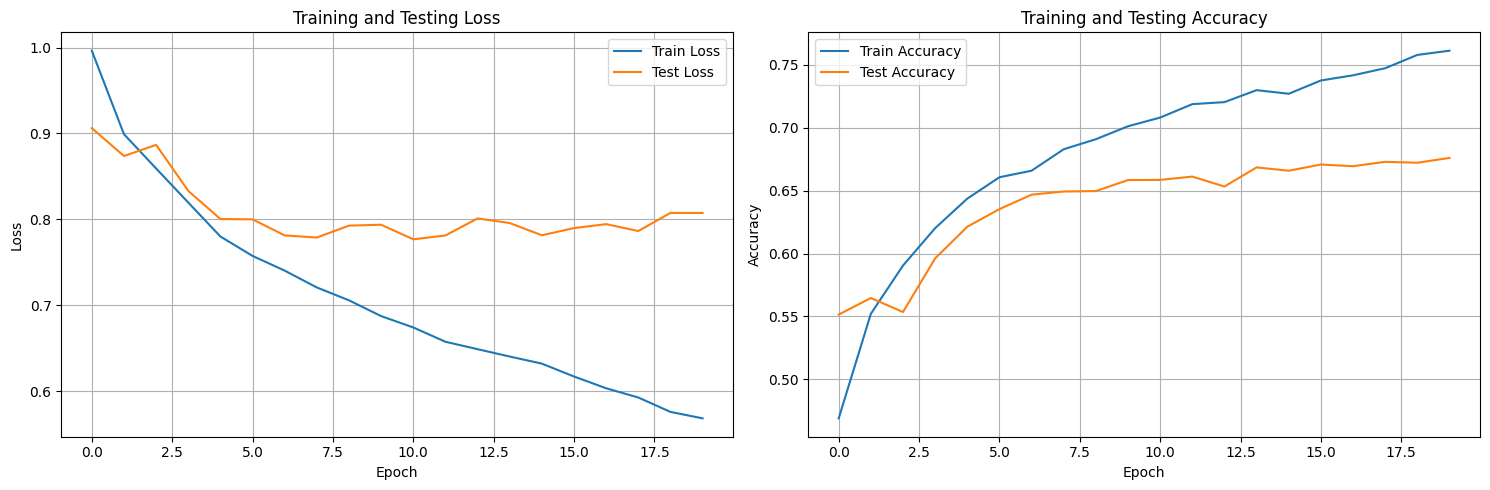

In [ ]:
# Train and evaluate
metrics = train_and_evaluate(x_train, y_train, x_test, y_test, model, **training_params)

# Visual Keras

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


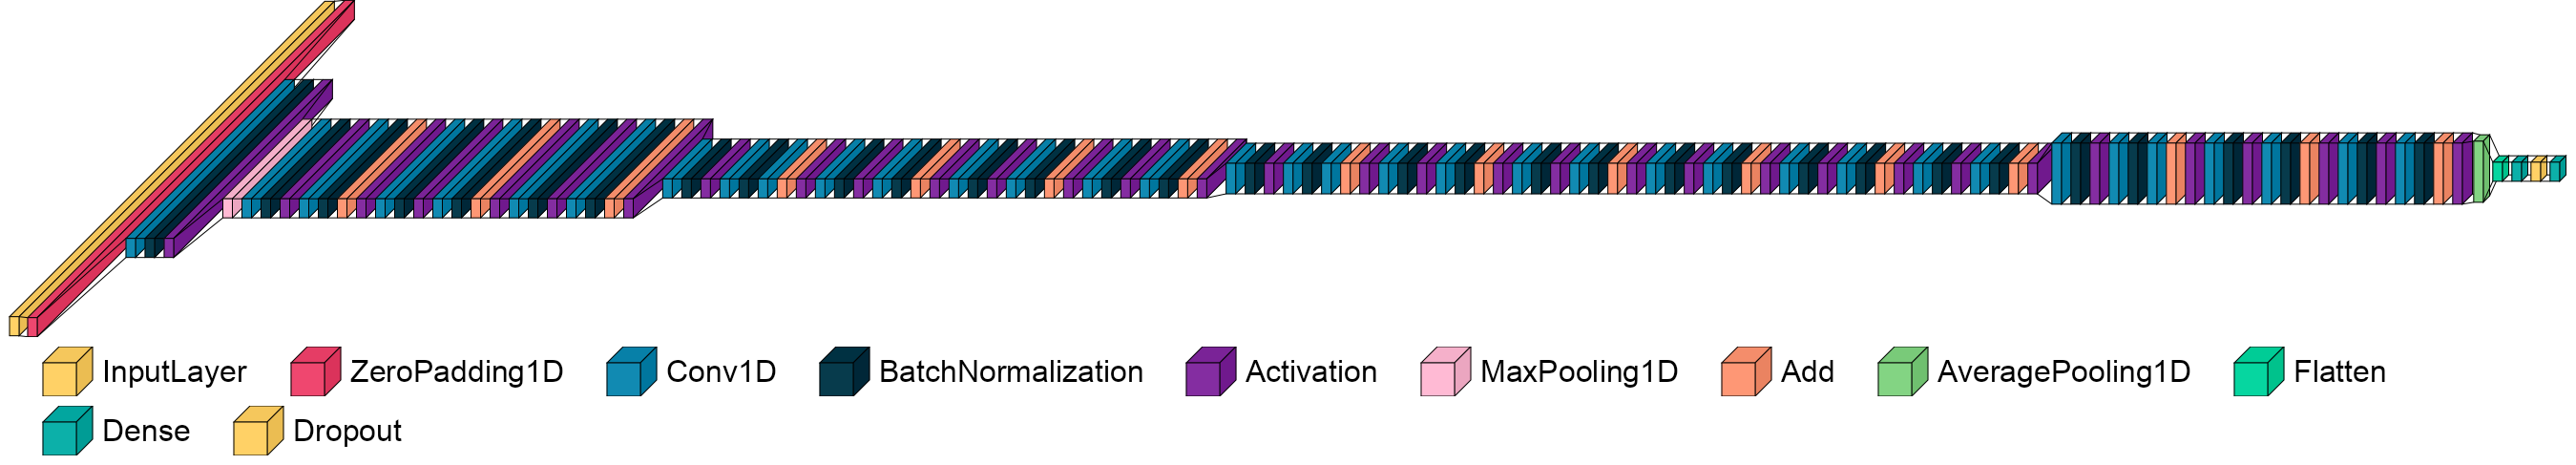

In [ ]:
font = ImageFont.truetype("/content/Arial.ttf", 32)
visualkeras.layered_view(resnet_model, legend=True, font=font, to_file='ResNet.png', scale_xy=1, scale_z=1, max_z=10)

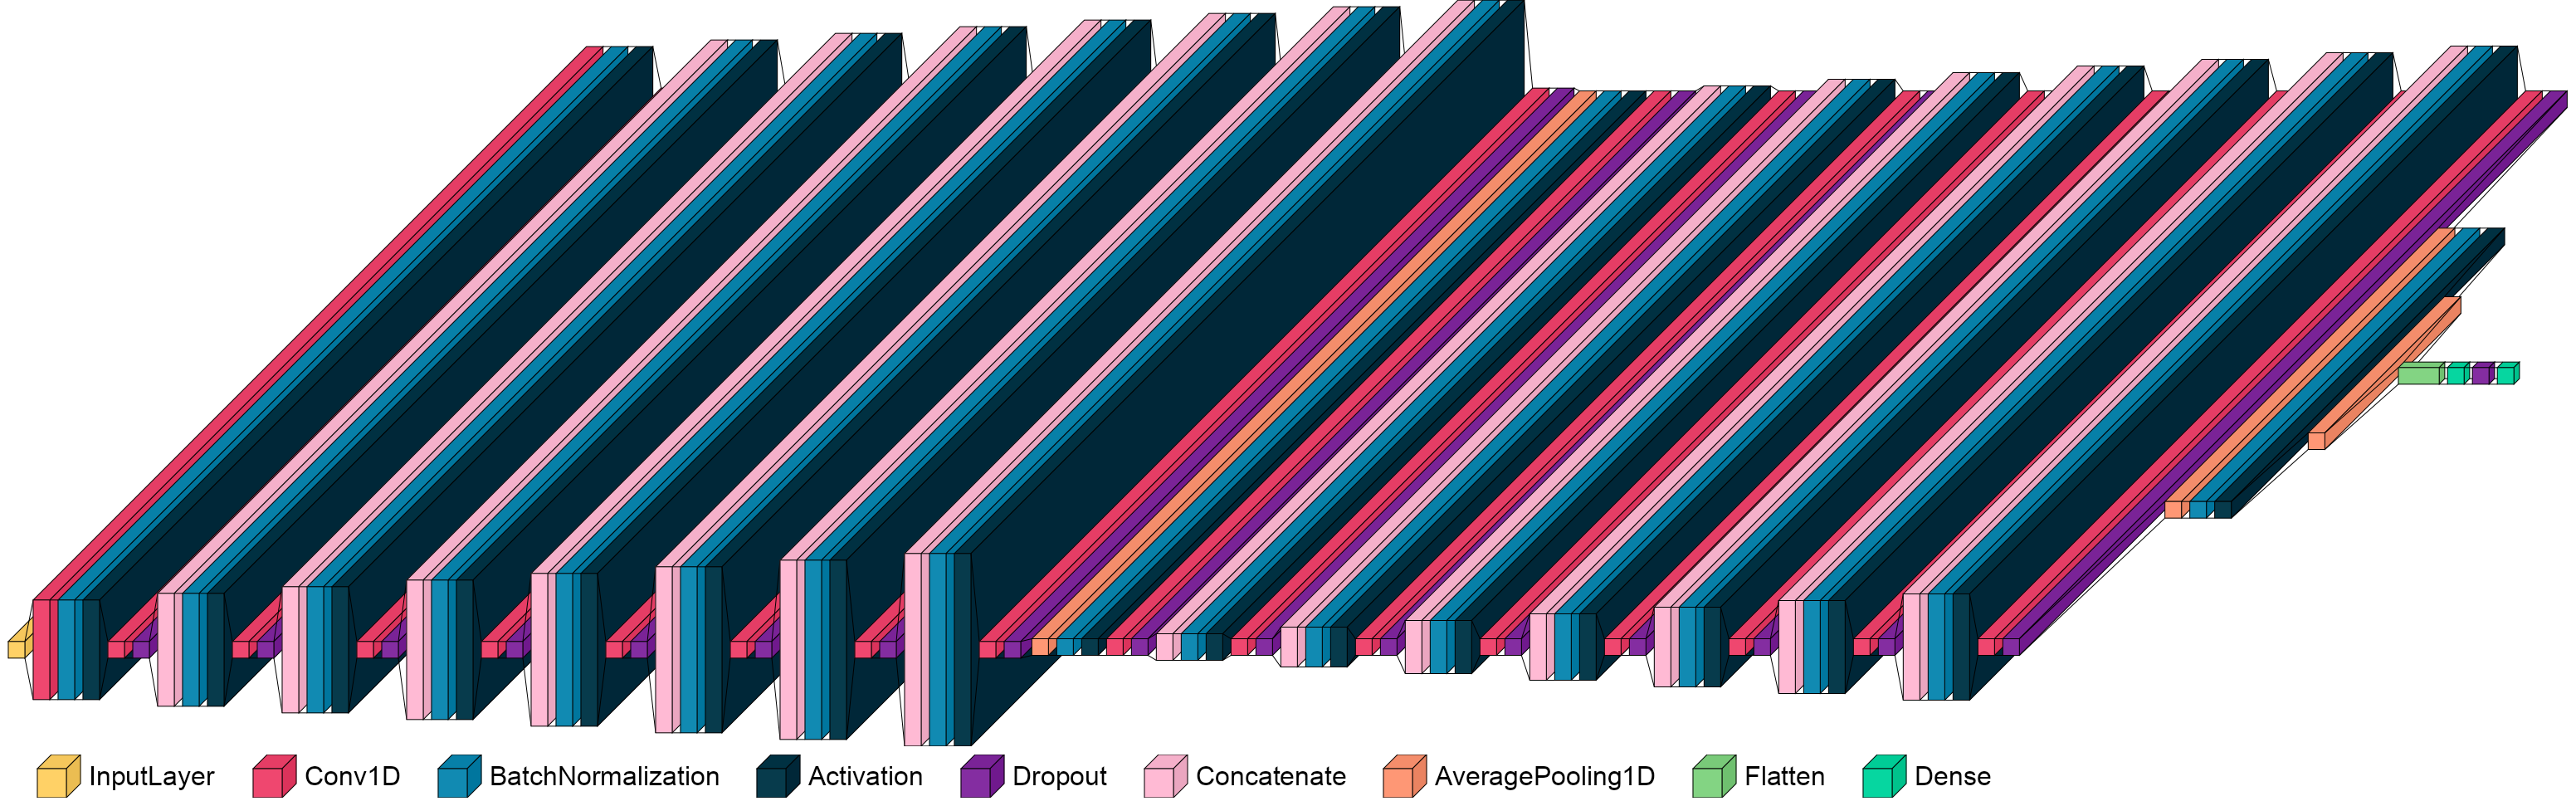

In [ ]:
visualkeras.layered_view(densenet_model, legend=True, font=font, to_file='DenseNet.png')

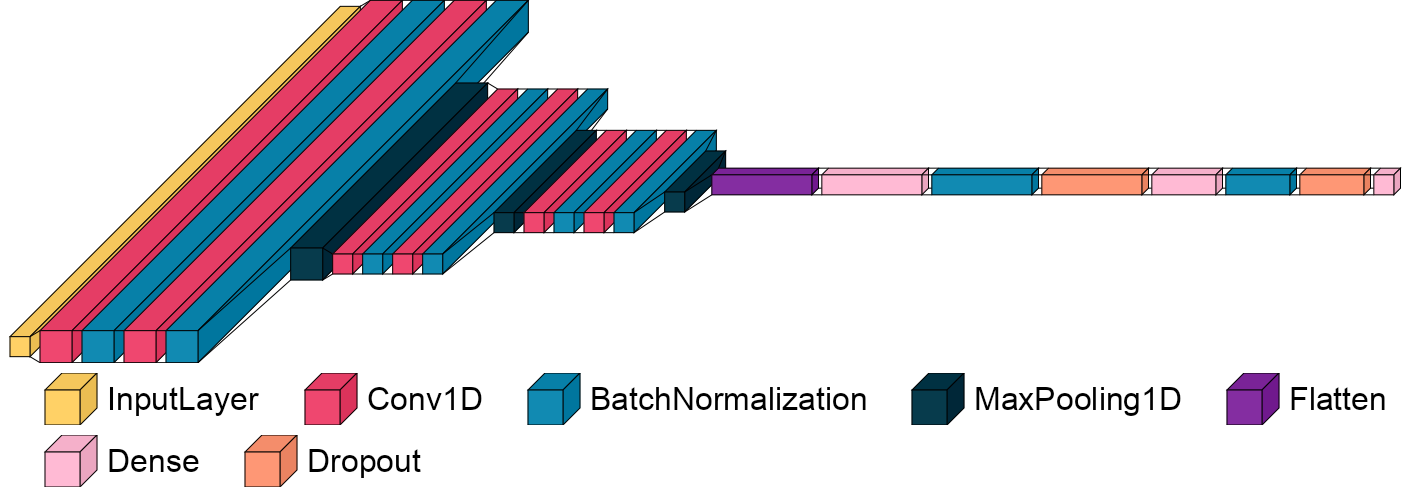

In [ ]:
visualkeras.layered_view(vgg16_1d_model, legend=True, font=font, to_file='VGG-Like.png', scale_xy=1, scale_z=1, max_z=100)